# Data Validation Report: Comparing Pressure Measurements from BOTPT and BPR
#### Evaluators: Jazlyn Natalie, Dax Soule

In this report, we analyze seafloor pressure measurements taken at The Axial Seamount's Central Caldera (RS03CCAL) by two co-located instruments: BOTPT (Bottom Pressure and Tilt Meter) and BPR. We selected December 30, 2014 and February 1, 2015 to be the start and end study time for this report. The original plan was to look at data from January 1 to February 1, 2015, but there is an issue with the January 1 data that corrupted the file associated with that day. However, moving the start time to December 30, 2014 rectified the problem.     

In [19]:
# Load map of Axial caldera showing locations of BOTPT instruments (red circles)
from IPython.display import Image
Image(url = "https://www.pmel.noaa.gov/eoi/rsn/Axial-2017-OOI-caldera-ed-sm.png")

In [20]:
#Zoomed in map of Axial caldera
from IPython.display import Image
Image(url = "https://www.pmel.noaa.gov/eoi/rsn/Axial-2017-OOI-zoom-ed-sm.png")

### API Information Setup

In [29]:
# USERNAME = ''
# TOKEN =  ''

### Import Python Libraries 

In [33]:
# First, we need to add some more Python libraries
import requests
import datetime
import time
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.dates as dates
import pickle as pk

In [34]:
import xarray as xr
import re
import requests
import os
import gc

### Downloading Data and Metadata

In [35]:
# API Login Information
username = ''
token = ''

# Sensor Base URL
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# Instrument Vocabulary
subsite = 'RS03CCAL'
node = 'MJ03F'
sensor = '05-BOTPTA301'
method = 'streamed'
stream = 'botpt_nano_sample'
beginDT = '2014-12-30T01:01:01.000Z'
endDT = '2015-02-01T01:01:01.000Z'

In [36]:
# Create the request URL
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))

# All of the following are optional
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}

In [37]:
print(data)

{'message': {'code': 400, 'status': 'Error in request time parameters:Invalid format: "1419897600000" is malformed at "0000" Supplied parameters = begin[1419897600000]/end[1422748800000]'}, 'status_code': 400}


## Annotations

In [38]:
USERNAME = ''
TOKEN = ''

# Specify a reference designator
refdes = 'RS03ASHS-MJ03B-09-BOTPTA304'

# Specify a time range of interest
# begin = int(datetime.date(2017,1,1).strftime('%s'))*1000
# end = int(datetime.date(2018,1,1).strftime('%s'))*1000

# Alternatively, if you want all annotations, use these dates
# beginDT = '2014-12-30T01:01:01.000Z'
# endDT = '2015-02-01T01:01:01.000Z'
begin = int(datetime.date(2014,12,30).strftime('%s'))*1000
end = int(datetime.date(2015,2,1).strftime("%s")) * 1000 # current date

In [39]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT': begin,
  'endDT': end,
  'refdes': refdes,
}

# Send the request
r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [40]:
# convert timestamps
def convert_time(ms):
    if ms != None:
        return datetime.datetime.utcfromtimestamp(ms/1000)
    else:
        return None

In [41]:
# Convert info the json response to a dataframe for easier visualization
# no stream specification means it's specific for the instrument 
df = pd.DataFrame() # Setup empty array
for d in data:
    df = df.append({
        'annotation_id': d['id'],
        'subsite': d['subsite'],
        'node': d['node'],
        'sensor': d['sensor'],
        'stream': d['stream'],
        'method': d['method'],
        'start': convert_time(d['beginDT']),
        'stop': convert_time(d['endDT']),
        'qcFlag': d['qcFlag'],
        'annotation': d['annotation']
    }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,annotation_id,method,node,qcFlag,sensor,start,stop,stream,subsite
0,Note: PNWGP Portland <-> Seattle outage,1074.0,None,None,None,None,2015-01-07 07:32:00,2015-01-07 08:06:00,None,RS03ASHS
1,Note: Intermittent partial data loss due to storage drive problems at OTB,1081.0,None,None,None,None,2015-01-31 00:00:00,2015-02-04 00:00:00,None,RS03ASHS


WARNING:
Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

## Data Request

In [43]:
# Data Request Line
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [1]:
# print(data['allURLs'][0])

In [2]:
# %%time
# check_complete = data['allURLs'][1] + '/status.txt'
# for i in range(1800): 
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#         time.sleep(1)

In [46]:
url='https://opendap.oceanobservatories.org/thredds/catalog/ooi/jazlynnatalie12@gmail.com/20180718T210007-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [47]:
print(datasets)

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/jazlynnatalie12@gmail.com/20180718T210007-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20150124T000000-20150131T222614.600000.nc', 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/jazlynnatalie12@gmail.com/20180718T210007-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20150115T000000-20150123T235959.950000.nc', 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/jazlynnatalie12@gmail.com/20180718T210007-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample_20150107T000000-20150114T235959.950000.nc', 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/jazlynnatalie12@gmail.com/20180718T210007-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/deployment0001_RS03CCAL-MJ03F-05-BOTP

### Create Output Directory

In [48]:
# make the output directory
new_dir = '15s_mean_data/'
if not os.path.isdir(new_dir):
    try:
        os.makedirs(new_dir)
    except OSError:
        if os.path.exists(new_dir):
            pass
        else:
            raise

### Downsample data

In [49]:
# read in the data directly off THREDDS and write out as subsampled pickled pandas dataframe
# NOTE: It takes about one hour to subsample 69499.81 Mbytes of data and write it out to a dataframe. 
num = 0
for i in datasets:
    print('Downsampling file {} of {}'.format(str(num + 1), str(len(datasets))))
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})
    
    botpt = pd.DataFrame()
    botpt['bottom_pressure'] = ds['bottom_pressure'].to_pandas().resample('15S').mean()
    del botpt.index.name

    botpt = botpt.dropna()

    out = '15s_mean_data/' + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    num = num +1

    with open(out, 'wb') as fh:
        pk.dump(botpt,fh)

    gc.collect()
print('Complete!')

Downsampling file 1 of 4
Downsampling file 2 of 4
Downsampling file 3 of 4
Downsampling file 4 of 4
Complete!


### Aggregrate downsampled data

In [50]:
# create a single file with all the pickled data.
botpt = pd.DataFrame()
for path, subdirs, files in os.walk('15s_mean_data/'):
#     files = files[1:]
    for name in files:
        file_name = os.path.join(path, name) 
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            botpt = botpt.append(pd_df)

botpt.index.name = 'time'
botpt = botpt.sort_values(by=['time'])

with open('botpt.pd', 'wb') as f:
    pk.dump(botpt,f)

In [52]:
# to open the first file
x = xr.open_dataset(datasets[0])
print(x)

<xarray.Dataset>
Dimensions:                      (obs: 13706494)
Coordinates:
  * obs                          (obs) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
    time                         (obs) datetime64[ns] ...
    lat                          (obs) float64 ...
    lon                          (obs) float64 ...
Data variables:
    deployment                   (obs) int32 ...
    id                           (obs) |S64 ...
    bottom_pressure              (obs) float32 ...
    date_time_string             (obs) object ...
    driver_timestamp             (obs) datetime64[ns] ...
    ingestion_timestamp          (obs) datetime64[ns] ...
    internal_timestamp           (obs) datetime64[ns] ...
    port_timestamp               (obs) datetime64[ns] ...
    preferred_timestamp          (obs) object ...
    press_trans_temp             (obs) float64 ...
    provenance                   |S64 ...
    sensor_id                    (obs) object ...
    time_sync_flag               object .

In [20]:
# obtain more information on data variables (specify by adding .units, .comment, etc)
x['bottom_pressure'].units

'psia'

psia = abbreviation for pressure units of pound(s)-force per square inch absolute. This pressure is referenced relative to a vacuum and includes the pressures exerted by both the water column and the atmosphere.

### Missing data 
The January 16, 2015 BOTPT data is missing. 

### Timeseries Plot of BOTPT

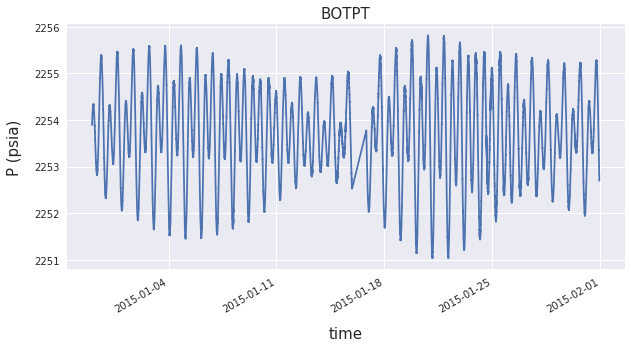

In [53]:
fig, (ax) = plt.subplots(figsize=(10,5))
botpt['bottom_pressure'].plot(axes=ax);
plt.ylabel('P (psia)', fontsize = 15, labelpad = 12)
plt.xlabel('time', fontsize = 15, labelpad = 12)
plt.title('BOTPT', fontsize = 15)
fig.savefig('data_eval_plots/botpt.svg', format='svg', dpi=1200)

### Converting pressure measurements from BOTPT to depth

In [54]:
botpt_corrected = (botpt['bottom_pressure']*.67)
botpt_mean = botpt_corrected.mean()
botpt_diff = botpt_corrected - botpt_mean
print(botpt_corrected)
# botpt.tail()

time
2014-12-30 01:01:00    1510.106555
2014-12-30 01:01:15    1510.107864
2014-12-30 01:01:30    1510.110481
2014-12-30 01:01:45    1510.112444
2014-12-30 01:02:00    1510.113916
2014-12-30 01:02:15    1510.114897
2014-12-30 01:02:30    1510.115388
2014-12-30 01:02:45    1510.116860
2014-12-30 01:03:00    1510.118987
2014-12-30 01:03:15    1510.120459
2014-12-30 01:03:30    1510.119641
2014-12-30 01:03:45    1510.118987
2014-12-30 01:04:00    1510.120623
2014-12-30 01:04:15    1510.122585
2014-12-30 01:04:30    1510.124058
2014-12-30 01:04:45    1510.125857
2014-12-30 01:05:00    1510.126838
2014-12-30 01:05:15    1510.127166
2014-12-30 01:05:30    1510.127493
2014-12-30 01:05:45    1510.129456
2014-12-30 01:06:00    1510.131582
2014-12-30 01:06:15    1510.132400
2014-12-30 01:06:30    1510.132727
2014-12-30 01:06:45    1510.134036
2014-12-30 01:07:00    1510.135508
2014-12-30 01:07:15    1510.135835
2014-12-30 01:07:30    1510.136816
2014-12-30 01:07:45    1510.139270
2014-12-30 01:0

Text(0.5,1,'BOTPT')

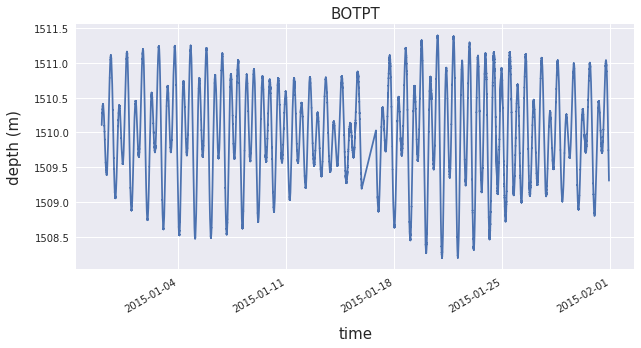

In [55]:
fig, (ax) = plt.subplots(figsize=(10,5))
botpt_corrected.plot(axes=ax)
plt.ylabel('depth (m)', fontsize = 15, labelpad = 12)
plt.xlabel('time', fontsize = 15, labelpad = 12)
plt.title('BOTPT', fontsize = 15)
# fig.savefig('data_eval_plots/depbotpt.svg', format='svg', dpi=1200)

### Importing BPR datasets 

In [56]:
bpr = xr.open_dataset('test1.nc')
bpr = bpr.swap_dims({'index': 'time'})
# df = botpt_bpr.to_dataframe()
# df.head()

### BPR measurements (already) in depth

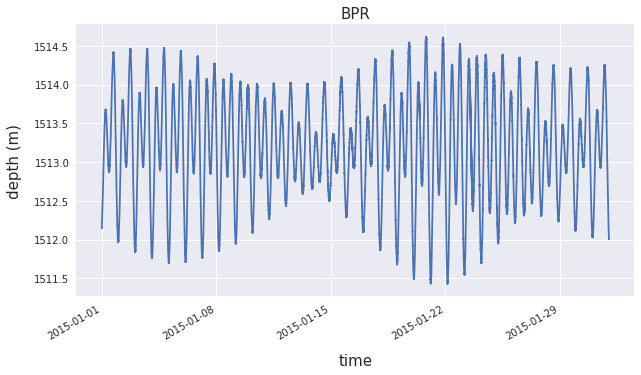

In [57]:
fig, (ax) = plt.subplots(figsize=(10,5))
bpr['DriftCorrRawDep'].plot(ax=ax);
plt.ylabel('depth (m)', fontsize = 15, labelpad = 12)
plt.xlabel('time', fontsize = 15, labelpad = 12)
plt.title('BPR', fontsize = 15)
fig.savefig('data_eval_plots/bpr.svg', format='svg', dpi=1200)

### Compare BOTPT and BPR measurements

Text(0.5,1,'BOTPT vs BPR')

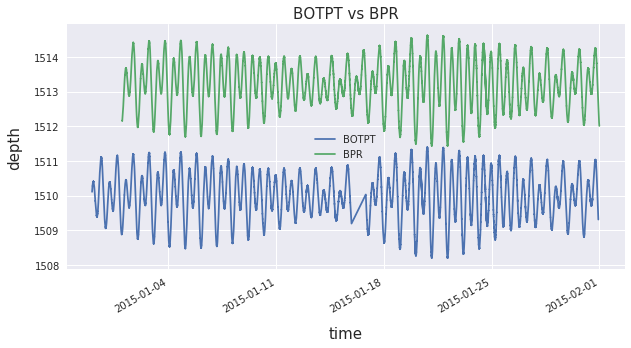

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(botpt_corrected,label='BOTPT')
botpt_corrected.plot(ax=ax);
bpr['DriftCorrRawDep'].plot(ax=ax);
ax.set_ylabel('depth',fontsize = 15, labelpad = 12)
ax.set_xlabel('time', fontsize = 15, labelpad = 12)
plt.legend(['BOTPT', 'BPR']);
plt.title('BOTPT vs BPR', fontsize = 15)
# fig.savefig('data_eval_plots/botptvsbpr.svg', format='svg', dpi=1200)

### Reduce each time series to the mean

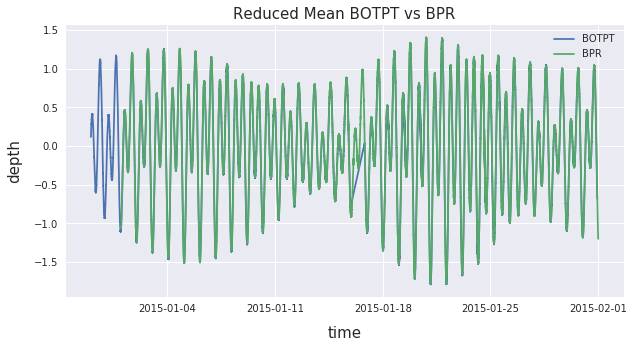

In [72]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(t,z-zm)
x = ax.plot(botpt_corrected - botpt_corrected.mean(),label='BOTPT')
y = plt.plot(bpr['time'],bpr['DriftCorrRawDep']-bpr['DriftCorrRawDep'].mean())
# x = ax.plot(botpt_corrected - botpt_corrected.mean(),label='BOTPT')
ax.set_ylabel('depth',fontsize = 15, labelpad = 12)
ax.set_xlabel('time', fontsize = 15, labelpad = 12)
plt.title('Reduced Mean BOTPT vs BPR', fontsize = 15)
plt.legend(['BOTPT', 'BPR']);
# ax.plot(botpt_bpr - botpt_bpr.mean())
# ax.plot(botpt_bpr['DriftCorrRawDep'] - zm,label='BOTPT at 1526 m')
# # ax.set_xlim(datetime.date(2015,1,1),datetime.date(2015,1,5))

# # # plt.savefig('data_eval_plots.eps', )
# # fig.savefig('data_eval_plots/meanofbotp.svg', format='svg', dpi=1200)

The BPR data obtained starts on January 1, 2015, thus the lack of data on the graph prior to that date. 

In [74]:
type(botpt_corrected)

pandas.core.series.Series

Identify start and end time for each plotted vector

In [75]:
# botpt_bpr['time'][0]

### Zooming in on the graph

In [76]:
t = bpr['time']
z = bpr['DriftCorrRawDep']
zm = z.mean()
zdiff = z - zm

# # v = botpt_corrected
# c = botpt_corrected['bottom_pressure']
# cm = c.mean()

In [77]:
a = bpr.to_dataframe()
b = pd.DataFrame(botpt_corrected)
c = pd.merge(a, b, how='inner',left_index=True,right_index=True)

(735606.0416666666, 735606.0833333334)

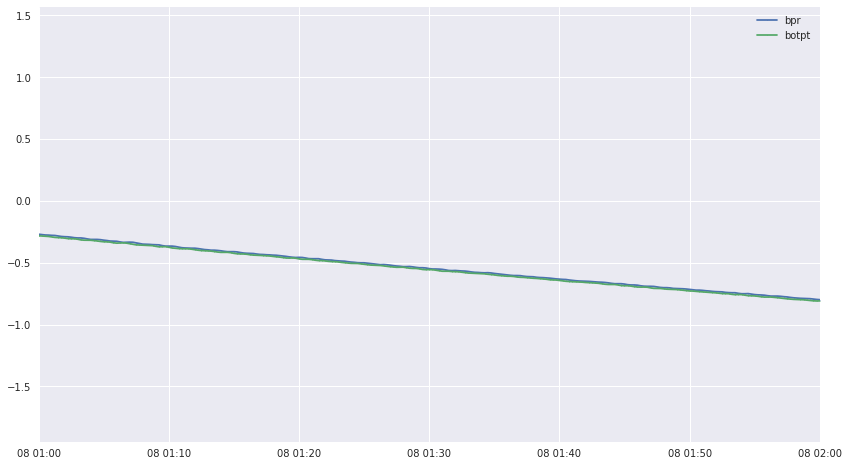

In [80]:
# c['DriftCorrRawDep'].plot()
# c['bottom_pressure'].plot()
fig,ax = plt.subplots(1,1,figsize=(14,8))
m1 = c['DriftCorrRawDep'].mean()
m2=c['bottom_pressure'].mean()
ax.plot(c.index, c['DriftCorrRawDep'] - m1,marker='.',markersize=1,linestyle=None,label='bpr')
ax.plot(c.index, c['bottom_pressure'] - m2,marker='.',markersize=1,label='botpt',linestyle=None)
plt.legend()
ax.set_xlim(datetime.datetime(2015,1,8,1,0,0),datetime.datetime(2015,1,8,2,0,0))

### Calculating Difference


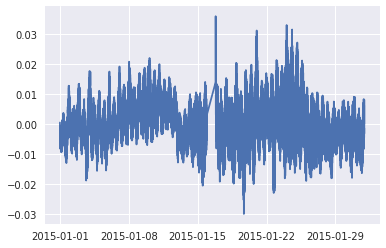

In [79]:
plt.plot(c.index,(c['DriftCorrRawDep']-m1) - (c['bottom_pressure']-m2));

In [86]:
print (botpt['bottom_pressure'].values)

[2253.8904 2253.8923 2253.8962 ... 2252.6987 2252.6987 2252.698 ]


## Conclusions: 
1. The reduced means of BOTPT and BPR match almost perfectly.   
2. BPR measurements fill in the missing gap (January 16, 2015) nicely when the two graphs are overlapped. 

#### Next step: Do analysis on longer timeseries. 